In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import scipy 

from scipy.special import logsumexp
from scipy.stats import gaussian_kde

import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

from real_gwb_likelihood_modified import GWBSpectrum

import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

import corner

2025-10-09 13:56:51.277301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
p_h_dt = np.genfromtxt("p_h.txt")

# EPTA DR2 total observation timespan
Tspan = 10.33 * 365.25 * 24 * 3600

# First 9 harmonics of 1/Tspan (< 1\yr)
fs = np.arange(1, 10) / Tspan
print('Frequencies (Hz)', fs)

h_grid = np.linspace(1e-15, 1e-13, 10000)

p_h = 1 / (h_grid[-1] - h_grid[0])
dh = h_grid[1] - h_grid[0]

Frequencies (Hz) [3.06757868e-09 6.13515737e-09 9.20273605e-09 1.22703147e-08
 1.53378934e-08 1.84054721e-08 2.14730508e-08 2.45406295e-08
 2.76082082e-08]


In [3]:
print('dh', dh)
print('p_h', p_h)
print('ln(dh)', np.log(dh))
print('ln(ph)', np.log(p_h))

dh 9.900990099009974e-18
p_h 10101010101010.1
ln(dh) -39.15389691175194
ln(ph) 29.943656544776093


In [4]:
gwb_functions = GWBSpectrum()

In [5]:
def LogLikelihood(theta):

    par0, par1, par2, par3, par4, par5 = theta

    mean, sigma, _ = gwb_functions.prediction6parameters_mean_sigma(freq=np.log10(fs), A=par0, alpha=par1, beta=par2, M0=par3, rho=par4, e0=par5)

    x = np.asarray(h_grid)
    x = x[:, None]             
    m = mean[None, :]            
    s = sigma[None, :] 
    prob_h = np.exp(-0.5 * ((x - m) / s)**2) / (s * np.sqrt(2 * np.pi)) # gaussian (mean, sigma)

    p_h_theta = prob_h * np.log(10) * (x/dh) # reweighted 
    
    log_p_h_theta = np.log(np.maximum(p_h_theta, 1e-300))
    log_p_h_dt = np.log(np.maximum(p_h_dt, 1e-300))

    logintegrand = np.log(dh) + log_p_h_dt + log_p_h_theta - np.log(p_h)

    logI = logsumexp(logintegrand)
    
    return np.sum(logI)

In [6]:
Amin,Amax=-7., 2.
alphamin,alphamax=0., 1.5
betamin,betamax=0.5, 2.
M0min,M0max=7., 9.
rhomin,rhomax=0., 5.
e0min,e0max=0., 0.99

def ptform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=alphamin,scale=alphamax-alphamin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=betamin,scale=betamax-betamin).ppf(u[2])
    x[3] = scipy.stats.uniform(loc=M0min,scale=M0max-M0min).ppf(u[3])
    x[4] = scipy.stats.uniform(loc=rhomin,scale=rhomax-rhomin).ppf(u[4])
    x[5] = scipy.stats.uniform(loc=e0min,scale=e0max-e0min).ppf(u[5])

    return x

In [26]:
ndim=6

# Define and run sampler
sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim, nlive=1000, bound='multi', sample='slice')
sampler.run_nested(print_progress=True)
sresults = sampler.results

2032it [20:02,  1.69it/s, +1000 | bound: 0 | nc: 1 | ncall: 10012 | eff(%): 33.644 | loglstar:   -inf < -27.731 <    inf | logz: -29.750 +/-    nan | dlogz:  0.001 >  1.009]


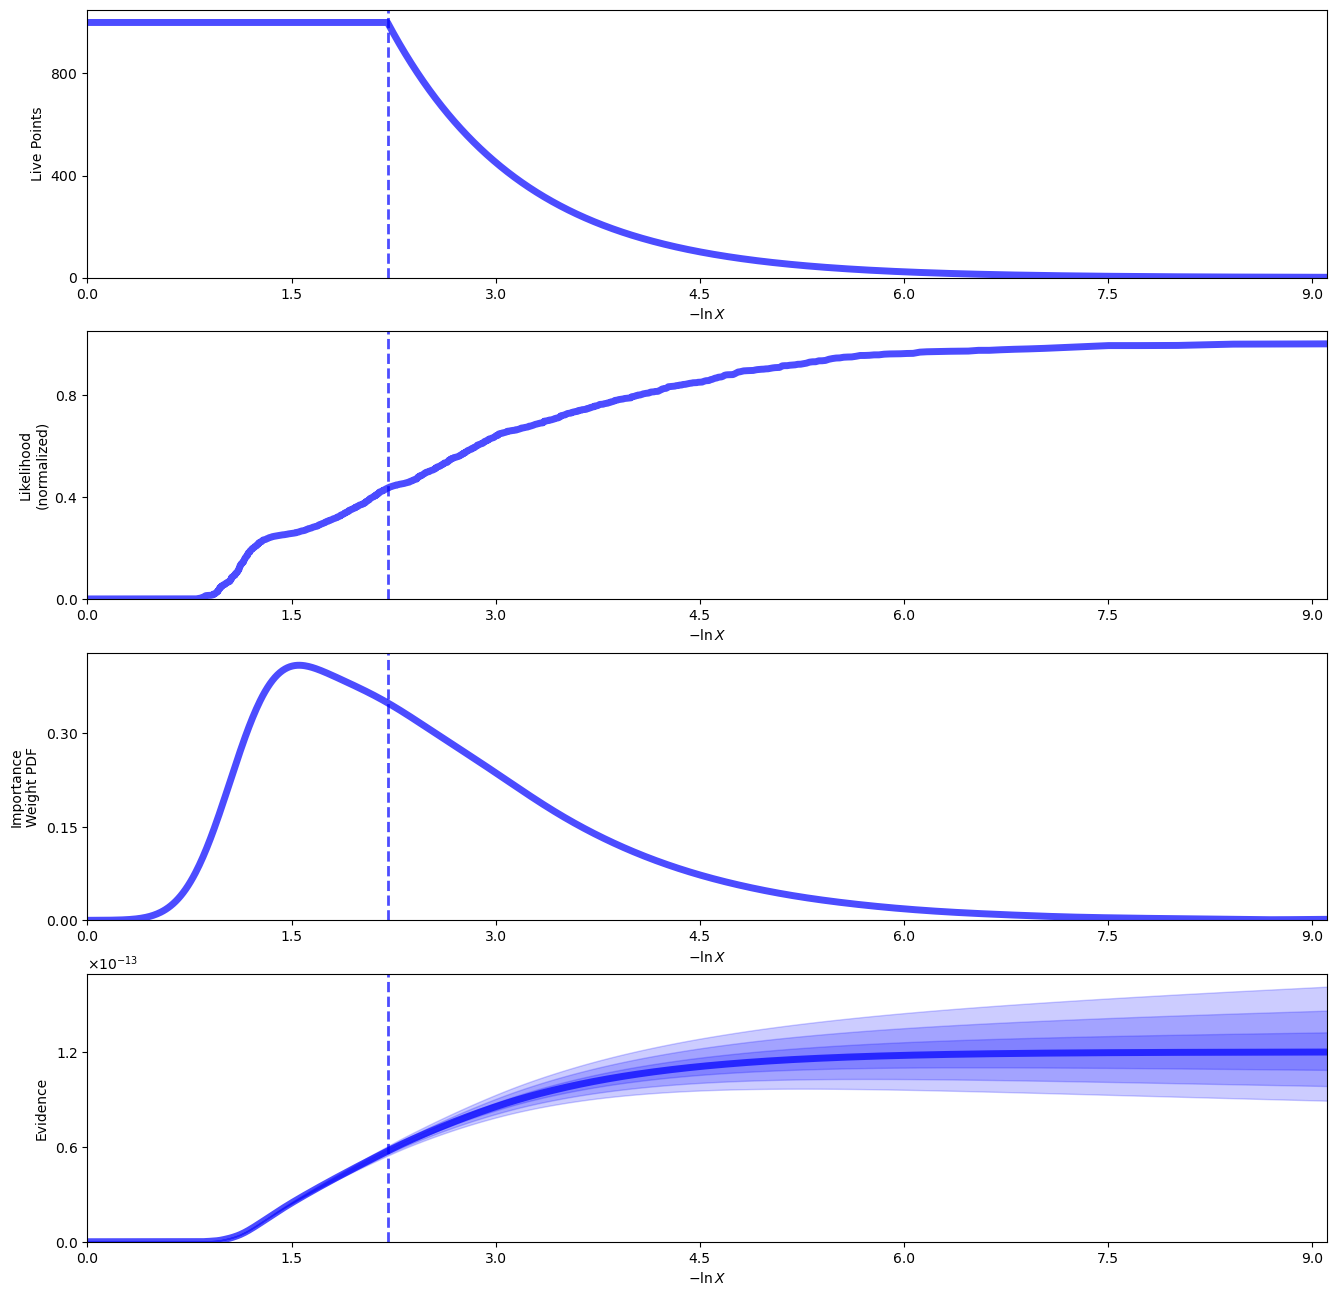

In [27]:
sresults = sampler.results
rfig, raxes = dyplot.runplot(sresults)

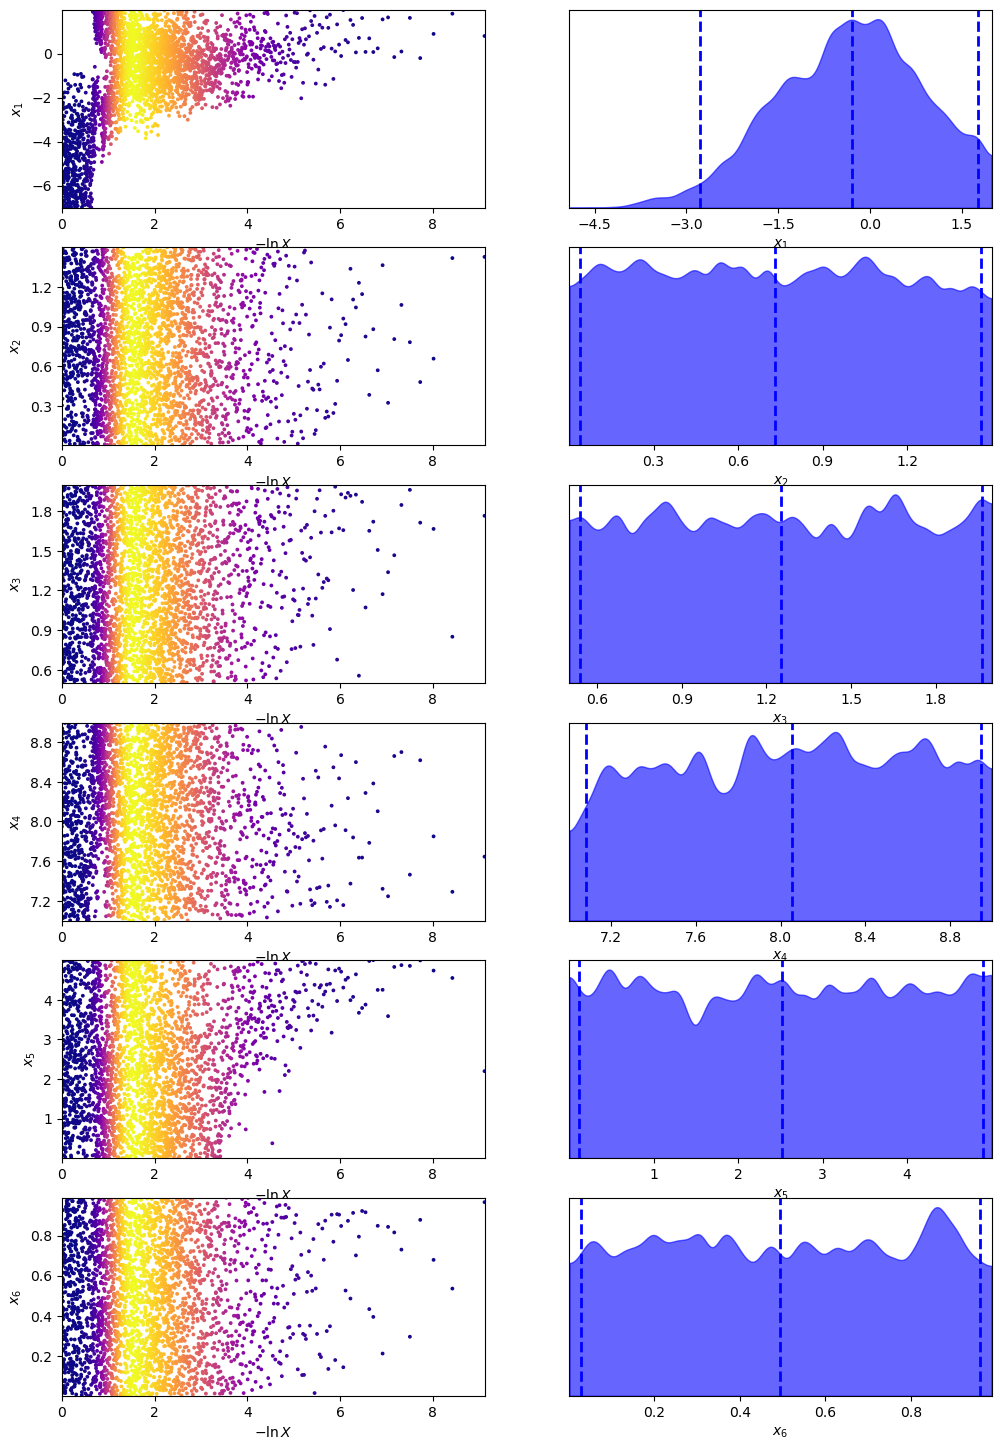

In [28]:
tfig, taxes = dyplot.traceplot(sresults)

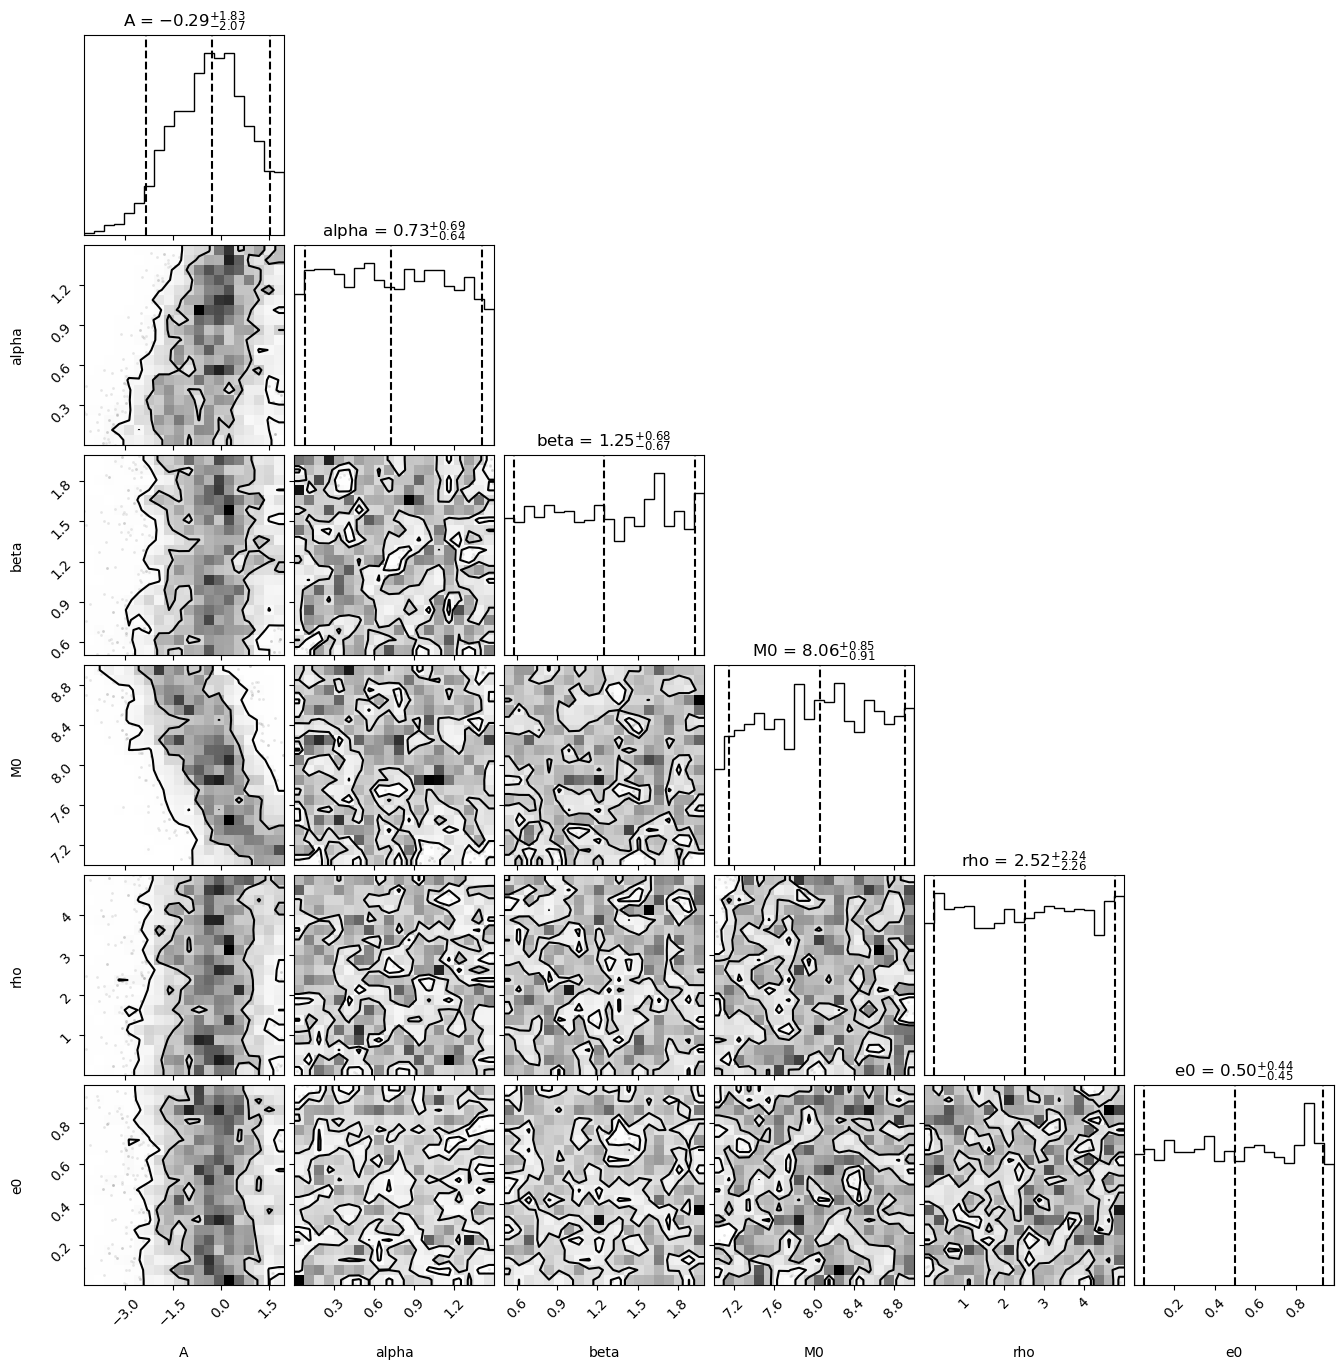

In [29]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

labels = ["A","alpha","beta","M0","rho","e0"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels, quantiles=[0.05,0.5,0.95], levels=[0.68,0.95], show_titles=True, smooth=0.5);

In [21]:
sresults.summary()

Summary
nlive: 2000
niter: 2713
ncall: 9266
eff(%): 50.863
logz: -29.681 +/-  0.093
